In [2]:
import sys
import subprocess
python = sys.executable
subprocess.check_call(
    [python, '-m', 'pip', 'install', '--upgrade', '-r', 'requirement.txt'],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT  #Suppress error messages
)

print(">>> requirements checked <<<\n")

>>> requirements checked <<<



In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [4]:
class GIRG:
    def __init__(self, n, d, tau, alpha, expected_weight):
        self.n = n
        self.d = d
        self.tau = tau
        self.alpha = alpha
        self.expected_weight = expected_weight
        self.positions = np.random.uniform(size=(n, d))
        self.weights = self._generate_weights(tau, expected_weight, n)
        self.graph = self._generate_graph()

    def _generate_weights(self, tau, expected_weight, size):
        return np.random.random(size)**(-1/(tau-1))*(expected_weight)*(tau-2)/(tau-1)

    def _distance_matrix(self):
        return squareform(pdist(self.positions))

    def _generate_graph(self):
        dist_matrix = self._distance_matrix()
        graph = nx.Graph()
        for i in range(self.n):
            for j in range(i + 1, self.n):
                p = 1 - np.exp(- (self.weights[i] * self.weights[j]) / (dist_matrix[i, j] ** self.d) ** self.alpha)
                if np.random.random() < p:
                    graph.add_edge(i, j)
        return graph

# Initialize the GIRG network
n = 1000  # Number of nodes
d = 2  # Dimensionality
tau = 2.5  # Power-law exponent for long-range network
alpha = 2  # Distance dependence exponent
expected_weight = 1  # Expected weight

print("Generating the network...")
girg = GIRG(n, d, tau, alpha, expected_weight)
G = girg.graph
print("Network generated.")

Generating the network...
Network generated.


In [5]:
# UPN-SEIRD model parameters
beta_u = 0.1  # Reduced infection rate to delay peak
beta_p = 0.2 * beta_u
beta_n = 0.2 * beta_u
sigma = 1 / 10  # Reduced transition rate from exposed to infected to delay peak
gamma = 1 / 14
f = 0.01
kappa = 1
lambda_plus = 1.0  # Increased transition rate to positive spreader
lambda_minus = 1.0  # Increased transition rate to negative spreader
delta_plus = 1 / 3  # Reduced forgetting rate for positive information
delta_minus = 1 / 3  # Reduced forgetting rate for negative information

# Adjusted initial conditions
initial_infected = 50  # Increased initial infected
initial_aware = 10  # Increased initial aware
N = len(G)
i_0 = initial_infected / N
a_0 = initial_aware / N

# Initialize state variables as floating-point arrays
S = np.full(N, 1.0, dtype=float)  # Specify dtype=float
E = np.zeros(N, dtype=float)
I = np.zeros(N, dtype=float)
R = np.zeros(N, dtype=float)
D = np.zeros(N, dtype=float)
U = np.full(N, 1.0 - a_0, dtype=float)  # Specify dtype=float
P = np.zeros(N, dtype=float)
N_nodes = np.zeros(N, dtype=float)

infected_nodes = np.random.choice(np.arange(N), initial_infected, replace=False)
aware_nodes = np.random.choice(np.arange(N), initial_aware, replace=False)

I[infected_nodes] = 1
U[aware_nodes] = 0
P[aware_nodes] = 1 - a_0

# Ensure U + P + N = 1 initially
U[aware_nodes] = 0
P[aware_nodes] = 1
N_nodes[aware_nodes] = 0
total = U + P + N_nodes
U /= total
P /= total
N_nodes /= total

# Time parameters
t_max = 150  # Maximum time
dt = 0.01  # Time step
time_steps = np.arange(0, t_max, dt)

# Initialize lists to store results
S_list = []
E_list = []
I_list = []
R_list = []
D_list = []
U_list = []
P_list = []
N_list = []

print("Starting the simulation...")
epsilon = 1e-10  # Small constant to avoid division by zero
adjacency_matrix = nx.to_numpy_array(G)  # Precompute adjacency matrix

for t_index, t in enumerate(time_steps):
    if t_index % 100 == 0:
        print(f"Simulation at time step {t_index}/{len(time_steps)} (time = {t:.1f})")
    
    # Precompute reused dot products
    dot_I = adjacency_matrix.dot(I)
    dot_P = adjacency_matrix.dot(P)
    dot_N_nodes = adjacency_matrix.dot(N_nodes)
    
    # Calculate transition probabilities
    new_E = (beta_u * S * dot_I) * dt
    new_I = (sigma * E) * dt
    new_R = ((1 - f) * gamma * I) * dt
    new_D = (f * gamma * I) * dt
    new_P = (lambda_plus * U * dot_P + kappa * I * U) * dt
    new_U_from_P = (delta_plus * P) * dt
    new_N = (lambda_minus * U * dot_N_nodes + kappa * I * U) * dt
    new_U_from_N = (delta_minus * N_nodes) * dt
    
    # Update states using in-place operations to reduce memory overhead
    np.clip(S - new_E, 0, 1, out=S)
    np.clip(E + new_E - new_I, 0, 1, out=E)
    np.clip(I + new_I - new_R - new_D, 0, 1, out=I)
    np.clip(R + new_R, 0, 1, out=R)
    np.clip(D + new_D, 0, 1, out=D)
    np.clip(U - new_P - new_N + new_U_from_P + new_U_from_N, 0, 1, out=U)
    np.clip(P + new_P - new_U_from_P, 0, 1, out=P)
    np.clip(N_nodes + new_N - new_U_from_N, 0, 1, out=N_nodes)
    
    # Normalize to ensure U + P + N = 1
    UPN_total = U + P + N_nodes + epsilon  # Add epsilon to avoid division by zero
    U /= UPN_total
    P /= UPN_total
    N_nodes /= UPN_total
    
    # Append current state to lists
    S_list.append(np.mean(S))
    E_list.append(np.mean(E))
    I_list.append(np.mean(I))
    R_list.append(np.mean(R))
    D_list.append(np.mean(D))
    U_list.append(np.mean(U))
    P_list.append(np.mean(P))
    N_list.append(np.mean(N_nodes))

print("Simulation complete. Plotting results...")

Starting the simulation...
Simulation at time step 0/15000 (time = 0.0)
Simulation at time step 100/15000 (time = 1.0)
Simulation at time step 200/15000 (time = 2.0)
Simulation at time step 300/15000 (time = 3.0)
Simulation at time step 400/15000 (time = 4.0)
Simulation at time step 500/15000 (time = 5.0)
Simulation at time step 600/15000 (time = 6.0)
Simulation at time step 700/15000 (time = 7.0)
Simulation at time step 800/15000 (time = 8.0)
Simulation at time step 900/15000 (time = 9.0)
Simulation at time step 1000/15000 (time = 10.0)
Simulation at time step 1100/15000 (time = 11.0)
Simulation at time step 1200/15000 (time = 12.0)
Simulation at time step 1300/15000 (time = 13.0)
Simulation at time step 1400/15000 (time = 14.0)
Simulation at time step 1500/15000 (time = 15.0)
Simulation at time step 1600/15000 (time = 16.0)
Simulation at time step 1700/15000 (time = 17.0)
Simulation at time step 1800/15000 (time = 18.0)
Simulation at time step 1900/15000 (time = 19.0)
Simulation at t

In [6]:
# Check the lengths of all arrays
print("Length of time_steps:", len(time_steps))
print("Length of S_list:", len(S_list))
print("Length of E_list:", len(E_list))
print("Length of I_list:", len(I_list))
print("Length of R_list:", len(R_list))
print("Length of D_list:", len(D_list))
print("Length of U_list:", len(U_list))
print("Length of P_list:", len(P_list))
print("Length of N_list:", len(N_list))

Length of time_steps: 15000
Length of S_list: 15000
Length of E_list: 15000
Length of I_list: 15000
Length of R_list: 15000
Length of D_list: 15000
Length of U_list: 15000
Length of P_list: 15000
Length of N_list: 15000


In [7]:
# load in the data as dataframe
import pandas as pd
data = {
    "Time": time_steps,
    "Susceptible": S_list,
    "Exposed": E_list,
    "Infected": I_list,
    "Recovered": R_list,
    "Deceased": D_list,
    "Unaware": U_list,
    "Positive": P_list,
    "Negative": N_list
}
df = pd.DataFrame(data)
print(df)

         Time    Susceptible       Exposed  Infected  Recovered      Deceased  \
0        0.00   9.570100e-01  4.299000e-02  0.049964   0.000035  3.571429e-07   
1        0.01   9.159263e-01  8.403076e-02  0.049972   0.000071  7.140306e-07   
2        0.02   8.766279e-01  1.232450e-01  0.050020   0.000106  1.070971e-06   
3        0.03   8.390057e-01  1.607440e-01  0.050107   0.000141  1.428256e-06   
4        0.04   8.029604e-01  1.966286e-01  0.050232   0.000177  1.786166e-06   
...       ...            ...           ...       ...        ...           ...   
14995  149.95  1.482197e-323  3.113261e-07  0.000079   0.990427  1.048389e-02   
14996  149.96  1.482197e-323  3.110148e-07  0.000079   0.990427  1.048389e-02   
14997  149.97  1.482197e-323  3.107038e-07  0.000079   0.990427  1.048389e-02   
14998  149.98  1.482197e-323  3.103931e-07  0.000079   0.990427  1.048389e-02   
14999  149.99  1.482197e-323  3.100827e-07  0.000079   0.990427  1.048389e-02   

        Unaware  Positive  

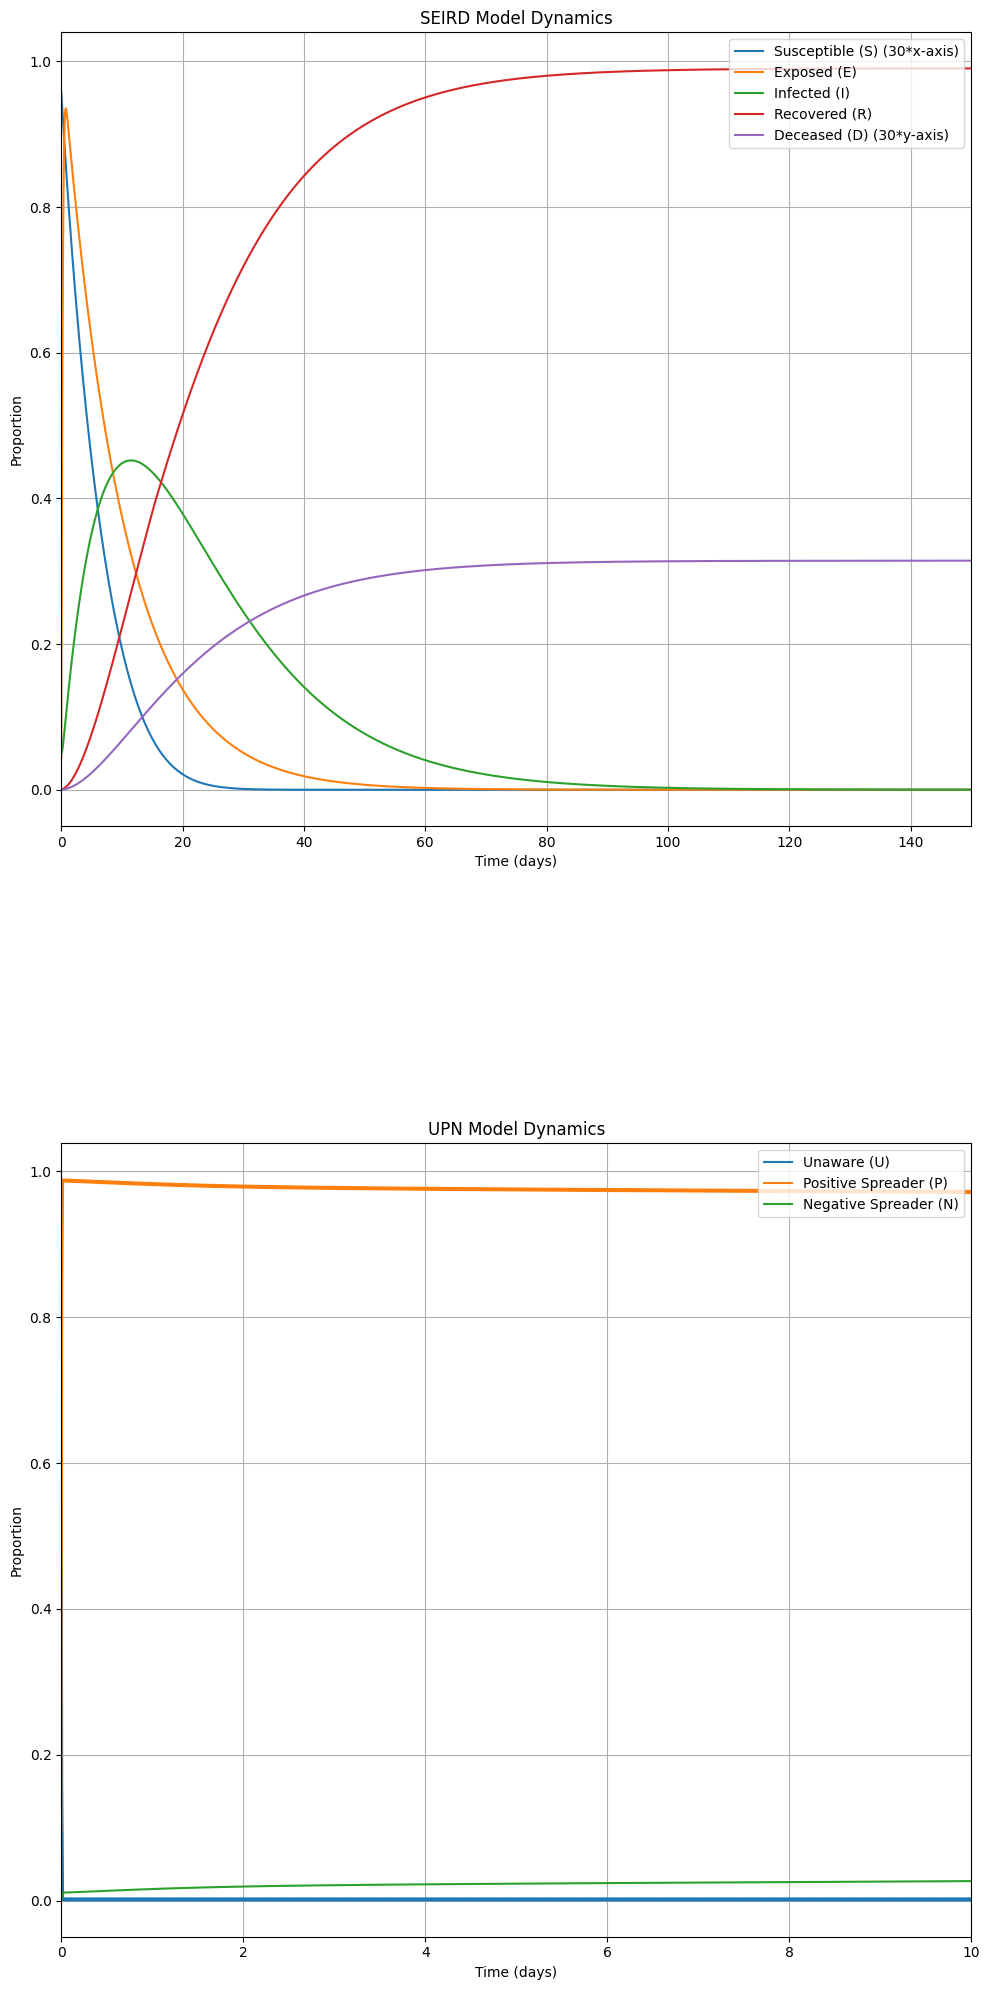

Plotting complete.


In [8]:
# Plotting results
fig, axs = plt.subplots(2, 1, figsize=(10, 20))

# Plot SEIRD components
axs[0].plot(time_steps * 30, S_list, label='Susceptible (S) (30*x-axis)')  # Expand x-axis by 50 for S
axs[0].plot(time_steps, E_list, label='Exposed (E)')
axs[0].plot(time_steps, I_list, label='Infected (I)')
axs[0].plot(time_steps, R_list, label='Recovered (R)')
axs[0].plot(time_steps, np.array(D_list) * 30, label='Deceased (D) (30*y-axis)')  # Expand y-axis by 50 for D
axs[0].set_xlabel('Time (days)')
axs[0].set_xlim([0, 150])  # Set x-axis range to 0-80 for SEIRD plot
axs[0].set_ylabel('Proportion')
axs[0].set_title('SEIRD Model Dynamics')
axs[0].grid(True)
axs[0].legend(loc='upper right')  # Move legend to the upper right

# Plot UPN components
axs[1].plot(time_steps, U_list, label='Unaware (U)')
axs[1].plot(time_steps, P_list, label='Positive Spreader (P)')
axs[1].plot(time_steps, N_list, label='Negative Spreader (N)')
axs[1].set_xlabel('Time (days)')
axs[1].set_xlim([0, 10])  # Set x-axis range to 0-5 for UPN plot
axs[1].set_ylabel('Proportion')
axs[1].set_title('UPN Model Dynamics')
axs[1].legend(loc='upper right')
axs[1].grid(True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Adjust the height space between subplots
plt.show()
print("Plotting complete.")